In [1]:
# Import the libraries.
# ~~~~~~~~~~~~~~~~~~~~~
import pandas as pd
from sklearn import decomposition
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import recall_score, roc_auc_score, precision_score
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

# GridSearchCV to find optimal min_samples_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')
import numpy as np
pd.set_option('display.max_columns', 500)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


### Preprocess Data

In [2]:
# Loading Data
churn_df = pd.read_csv(r'telecom_churn_data.csv')
# Back up the original df
churn_original = churn_df.copy()

# Understanding Data quality
# ~~~~~~~~~~~~~~~~~~~~~~~~~~

# Has missing values
print(churn_df.info(verbose=1))
# Not normally distributed
print(churn_df.describe())
# Has class imbalance
print(churn_df.describe(include='object'))
# No duplicate Rows
print(sum(churn_df.duplicated()))


# different type of columns
id_columns = ['mobile_number', 'circle_id']
date_columns = [col for col in churn_df.columns if 'date' in col]
categorical_columns = [col for col in churn_df.columns if 'night_pck' in col or 'fb_user' in col]
numeric_columns = [col for col in churn_df.columns if col not in id_columns+date_columns+categorical_columns]

# 40 most missing data columns are as listed below where missing % is more than 70%
most_missing_cols = list(pd.Series(churn_df.isnull().sum()*100/churn_df.shape[0]).sort_values().tail(40).index)
for mon in (6,7,8,9):
    l = [x for x in most_missing_cols if '_'+str(mon) in x]
    l.sort()
    print('Missing values in month',mon,'\n----------------------------------')
    print(pd.Series(churn_df[l].isnull().sum()*100/churn_df.shape[0]))

#- The % missing data is exactly the same for all the columns with subscript _6, _7, _8 and _9
#- One important observation here is where ever date_of_last_rech_data_[month] is missing all other informations related to 
#  data are also missing so we can impute them with 0
#- Because when there was no data recharge in that month there is no utlilization available for the mobile number as well

# imputing with zero
for col in most_missing_cols:
    if 'date_of_last_rech_data_' not in col:
        churn_df[col].fillna(0, inplace = True)

# let us drop the date columns
churn_df_drpd = churn_df.drop(columns=date_columns)

# understanding remaining missing data columns
for mon in ['6','7','8','9']:
    col_mon = [col for col in churn_df_drpd.columns if mon in col]
    print(pd.Series(churn_df_drpd[col_mon].isnull().sum()*100/churn_df_drpd.shape[0]).sort_values())

#dropping id columns
churn_df_drpd=churn_df_drpd.drop(columns=id_columns)

# Derived Matrix (to identify the high profile/ high value customers)
churn_df_drpd['total_revenue_6'] = churn_df_drpd['total_rech_amt_6'] + (churn_df_drpd['total_rech_data_6'] * churn_df_drpd['av_rech_amt_data_6'])
churn_df_drpd['total_revenue_7'] = churn_df_drpd['total_rech_amt_7'] + (churn_df_drpd['total_rech_data_7'] * churn_df_drpd['av_rech_amt_data_7'])
churn_df_drpd['avg_revenue_6_7'] = (churn_df_drpd['total_revenue_6'] + churn_df_drpd['total_revenue_7'])/2

# choosing 70th percentile as the cutoff for high value customer identification
high_value_cust_df = churn_df_drpd.loc[churn_df_drpd.avg_revenue_6_7 > churn_df_drpd.avg_revenue_6_7.quantile(0.7)]

# imputing median for missing data as most of columns are not normally distributed
for col in high_value_cust_df.columns:
    if sum(high_value_cust_df[col].isnull()) > 0 :
        high_value_cust_df[col].fillna((high_value_cust_df[col].median(skipna=True)), inplace=True)

# function for getting churn or no churn information
def ischurn(x):
    if x[['total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9', 'vol_3g_mb_9']].sum() == 0:
        return 1
    else:
        return 0

# applying the ischurn function
high_value_cust_df['churn'] = high_value_cust_df.apply(ischurn, axis=1)

print(sum(high_value_cust_df.churn)/high_value_cust_df.shape[1])

# removing the columns for 9th month i.e. the churn period
high_value_cust_drp1=high_value_cust_df.drop([col for col in high_value_cust_df.columns if "_9" in col],axis=1)
# removing the columns with only single value in the column or derived matrix for high value customer detection
high_value_cust_drp2=high_value_cust_drp1.drop(["loc_og_t2o_mou","std_og_t2o_mou",
                                                "loc_ic_t2o_mou", "std_og_t2c_mou_6", 
                                                "std_og_t2c_mou_7", "std_og_t2c_mou_8", 
                                                "std_ic_t2o_mou_6", "std_ic_t2o_mou_7", 
                                                "std_ic_t2o_mou_8","total_revenue_6",
                                                "total_revenue_7", "avg_revenue_6_7"], axis=1)

# derive matrix for churn customers better identification
col_6=[col for col in high_value_cust_drp2.columns if "_6" in col]
col_7=[col for col in high_value_cust_drp2.columns if "_7" in col]
col_8=[col for col in high_value_cust_drp2.columns if "_8" in col]
for i in range(len(col_6)):
    high_value_cust_drp2[col_6[i]+"_7_diff"]=high_value_cust_drp2[col_8[i]]-(high_value_cust_drp2[col_6[i]]+high_value_cust_drp2[col_7[i]])/2

col_diff=[col for col in high_value_cust_drp2.columns if "_diff" in col]

# capping the outliers to 3rd standard deviation on each side to remove any high bias outliers
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

cols=list(high_value_cust_drp2.columns)
cols.remove("churn")

high_value_cust_drp2[cols] = high_value_cust_drp2[cols].apply(cap_outliers, axis=0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 226 columns):
mobile_number               int64
circle_id                   int64
loc_og_t2o_mou              float64
std_og_t2o_mou              float64
loc_ic_t2o_mou              float64
last_date_of_month_6        object
last_date_of_month_7        object
last_date_of_month_8        object
last_date_of_month_9        object
arpu_6                      float64
arpu_7                      float64
arpu_8                      float64
arpu_9                      float64
onnet_mou_6                 float64
onnet_mou_7                 float64
onnet_mou_8                 float64
onnet_mou_9                 float64
offnet_mou_6                float64
offnet_mou_7                float64
offnet_mou_8                float64
offnet_mou_9                float64
roam_ic_mou_6               float64
roam_ic_mou_7               float64
roam_ic_mou_8               float64
roam_ic_mou_9               float6

       mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  \
count   9.999900e+04    99999.0         98981.0         98981.0   
mean    7.001207e+09      109.0             0.0             0.0   
std     6.956694e+05        0.0             0.0             0.0   
min     7.000000e+09      109.0             0.0             0.0   
25%     7.000606e+09      109.0             0.0             0.0   
50%     7.001205e+09      109.0             0.0             0.0   
75%     7.001812e+09      109.0             0.0             0.0   
max     7.002411e+09      109.0             0.0             0.0   

       loc_ic_t2o_mou        arpu_6        arpu_7        arpu_8        arpu_9  \
count         98981.0  99999.000000  99999.000000  99999.000000  99999.000000   
mean              0.0    282.987358    278.536648    279.154731    261.645069   
std               0.0    328.439770    338.156291    344.474791    341.998630   
min               0.0  -2258.709000  -2014.045000   -945.808000  -1899.5

       last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
count                 99999                99398                98899   
unique                    1                    1                    1   
top               6/30/2014            7/31/2014            8/31/2014   
freq                  99999                99398                98899   

       last_date_of_month_9 date_of_last_rech_6 date_of_last_rech_7  \
count                 98340               98392               98232   
unique                    1                  30                  31   
top               9/30/2014           6/30/2014           7/31/2014   
freq                  98340               16960               17288   

       date_of_last_rech_8 date_of_last_rech_9 date_of_last_rech_data_6  \
count                96377               95239                    25153   
unique                  31                  30                       30   
top              8/31/2014           9/29/2014       

11.26388888888889


### EDA for understanding data distribution

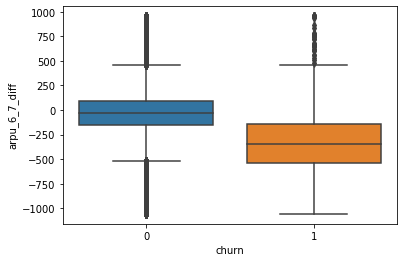

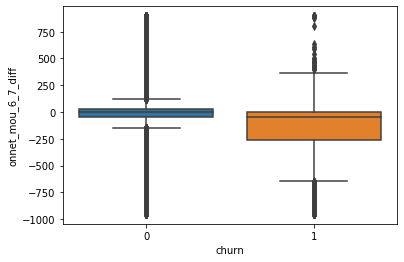

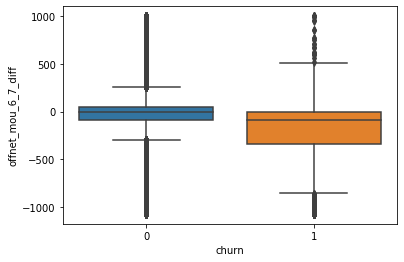

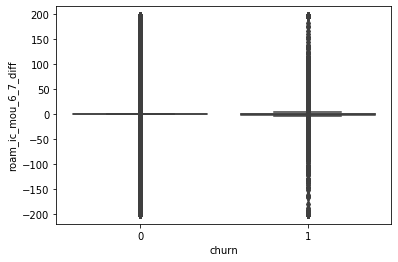

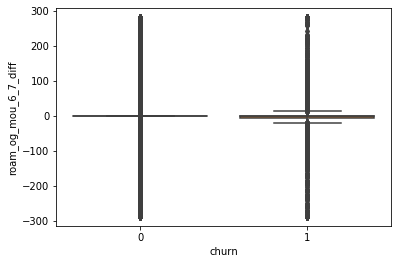

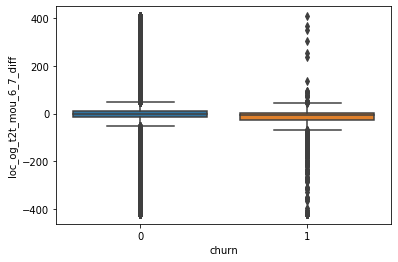

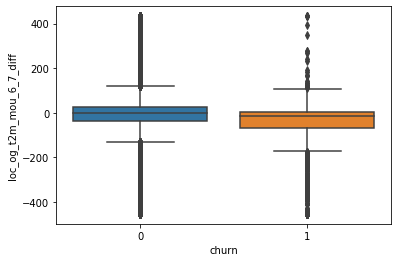

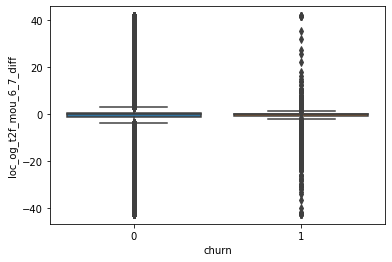

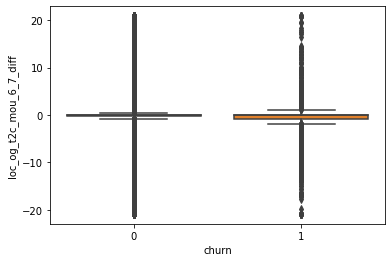

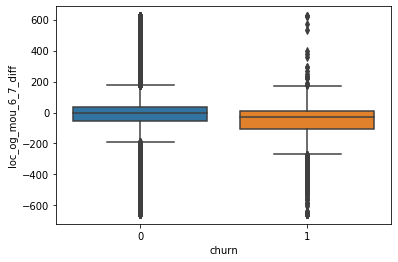

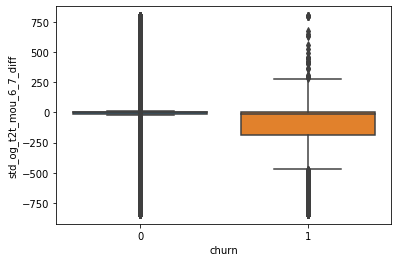

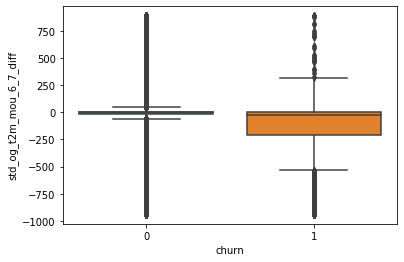

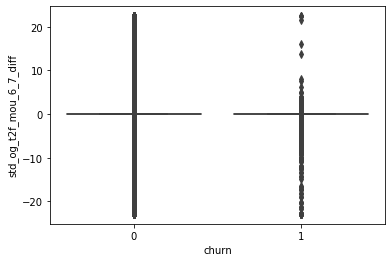

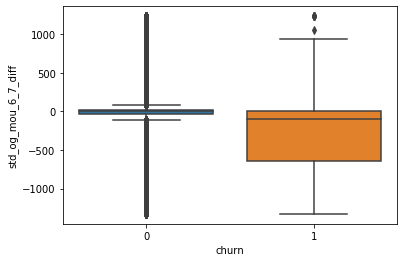

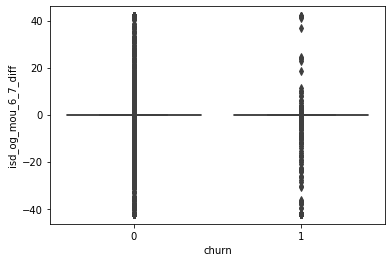

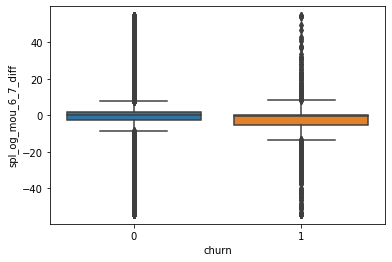

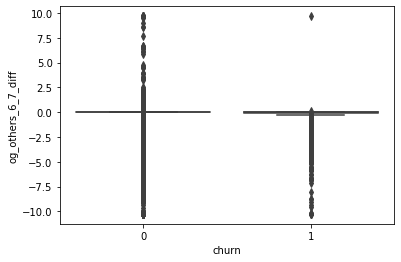

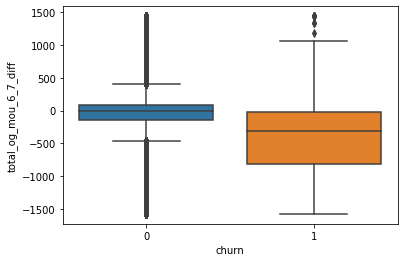

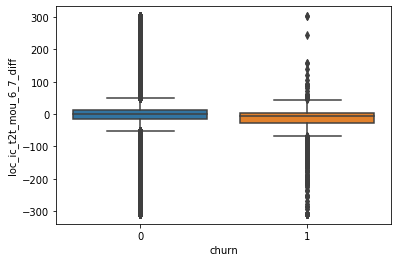

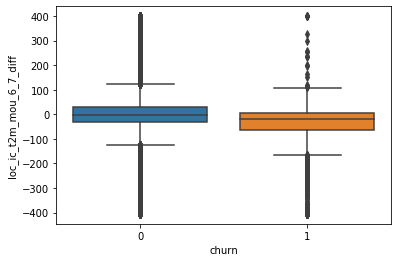

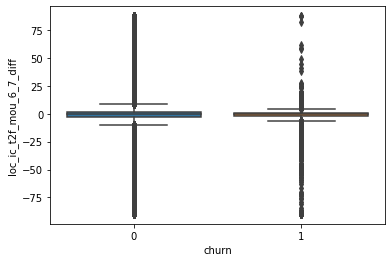

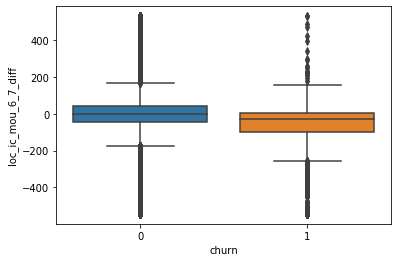

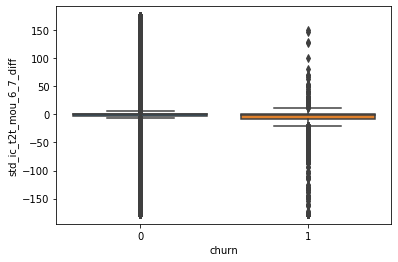

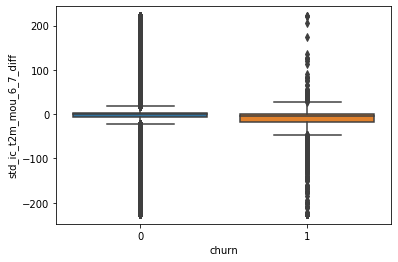

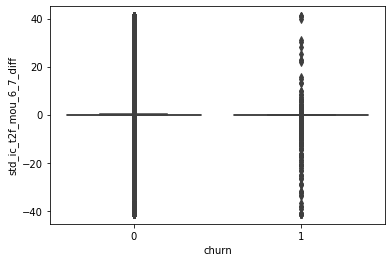

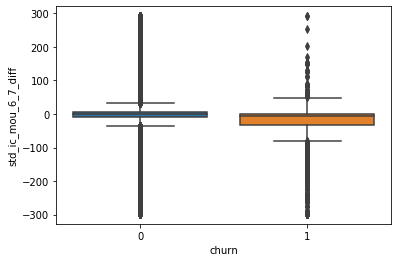

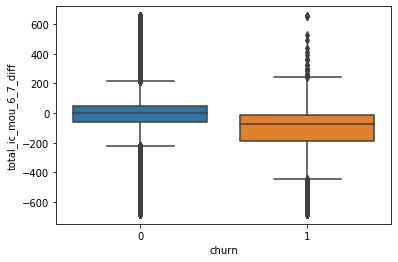

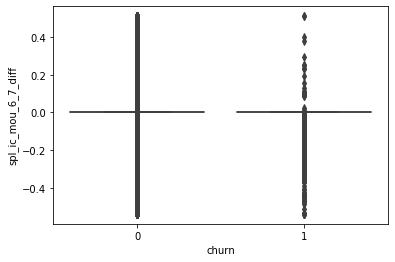

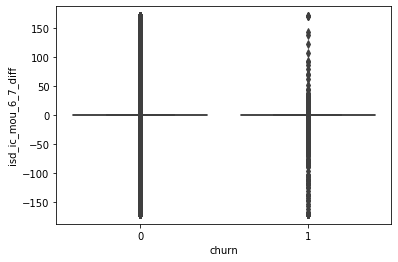

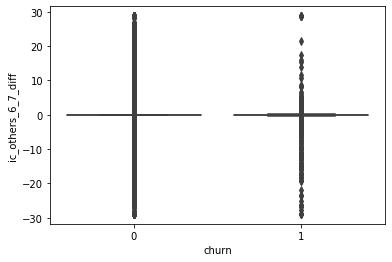

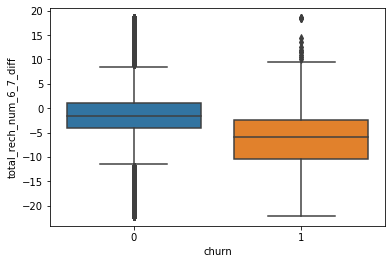

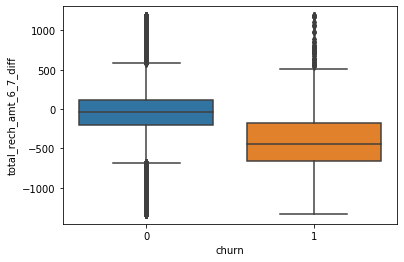

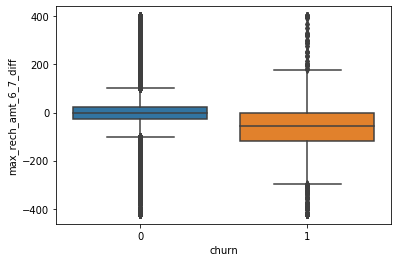

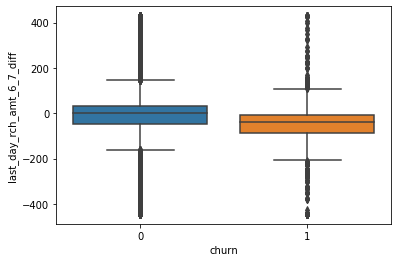

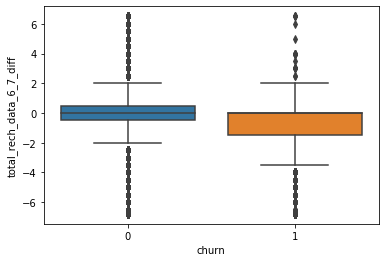

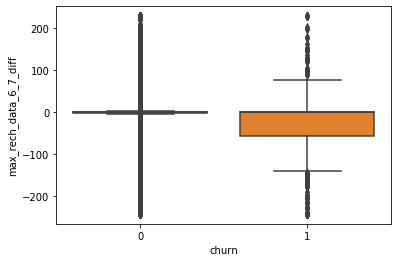

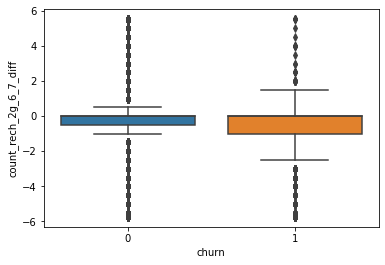

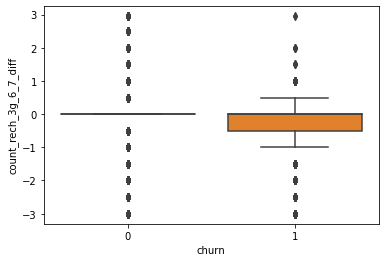

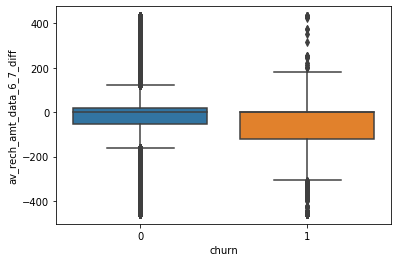

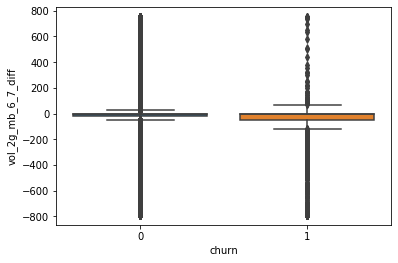

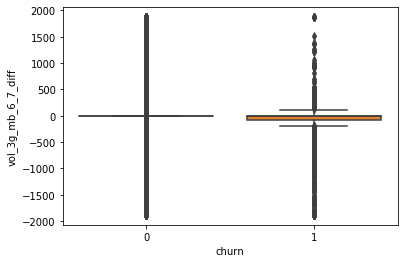

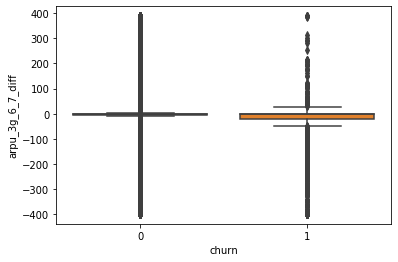

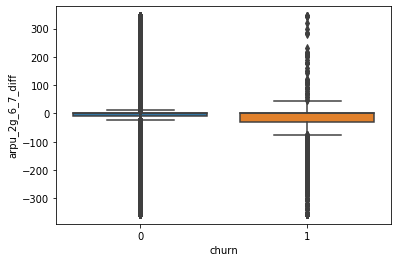

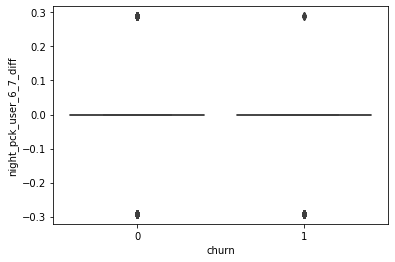

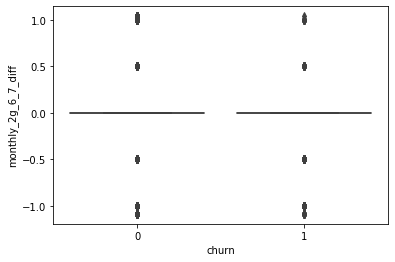

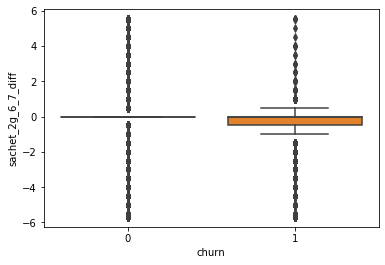

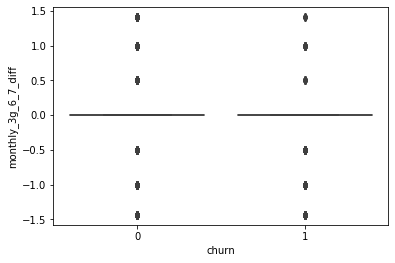

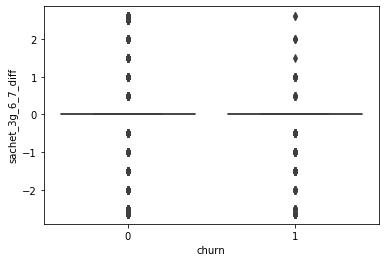

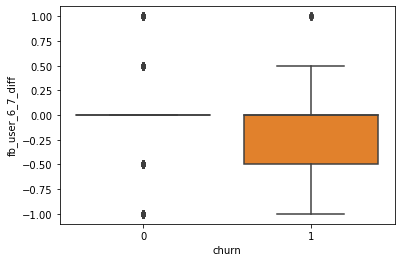

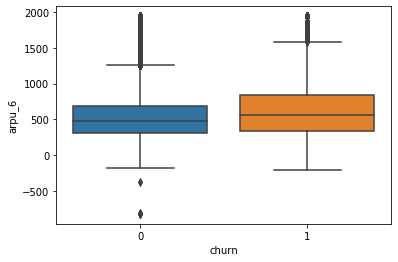

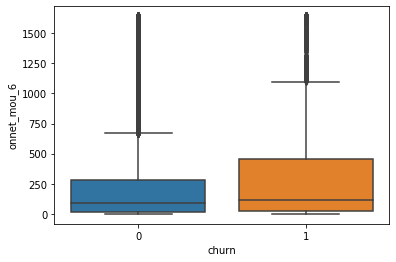

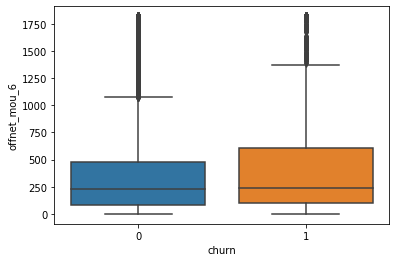

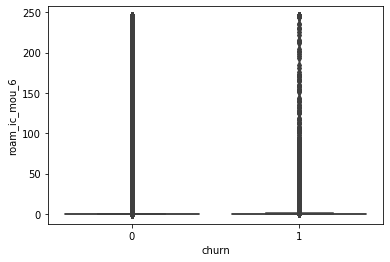

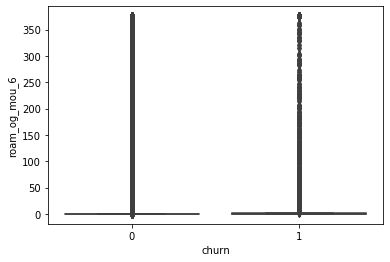

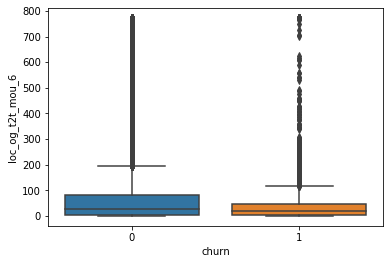

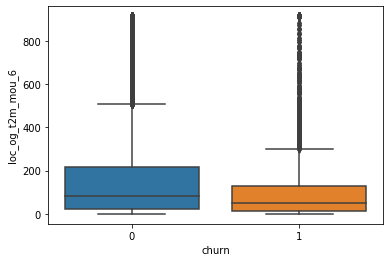

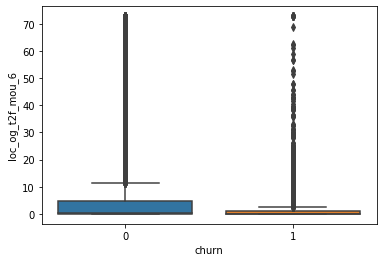

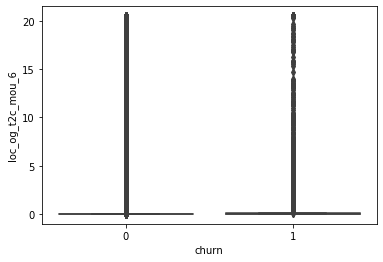

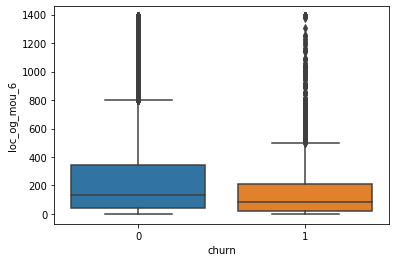

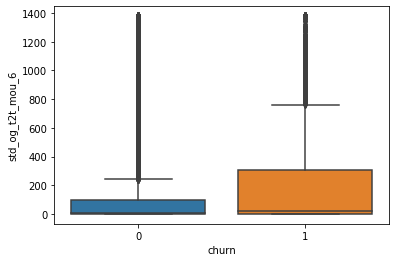

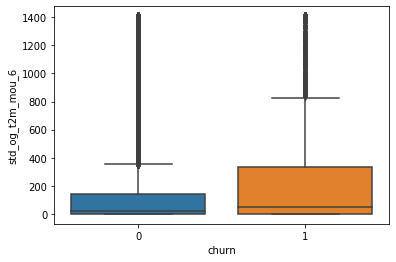

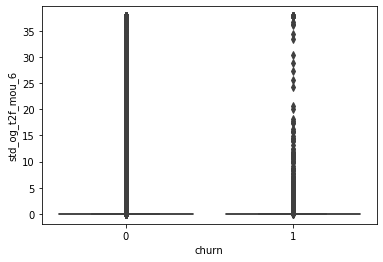

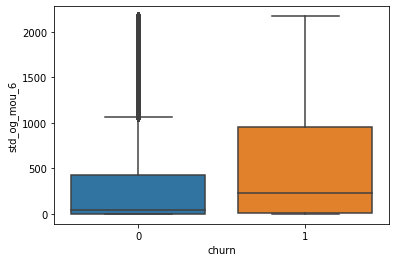

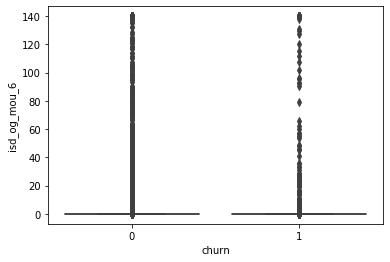

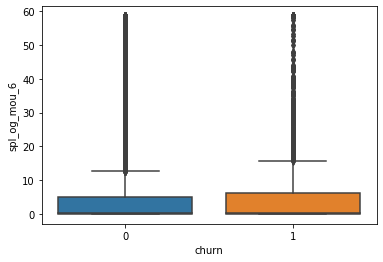

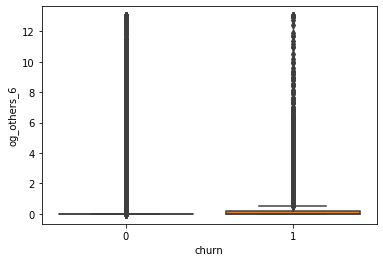

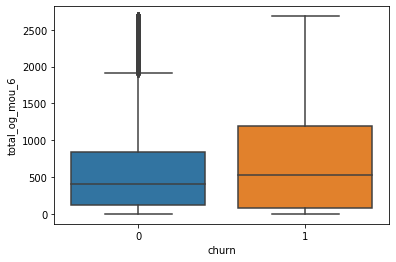

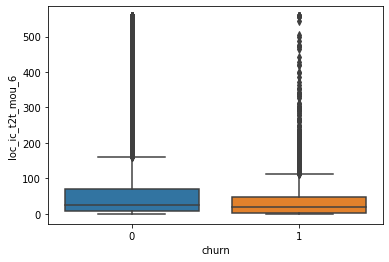

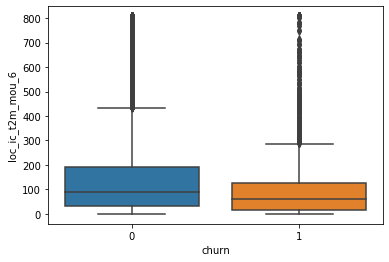

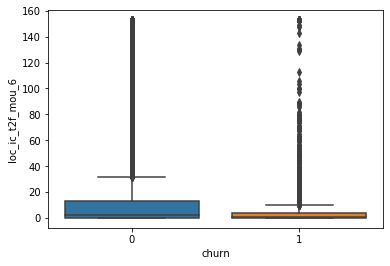

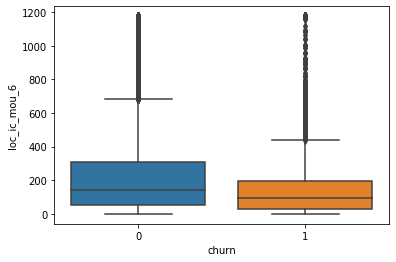

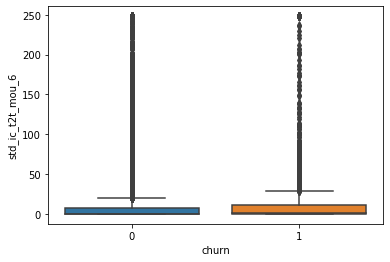

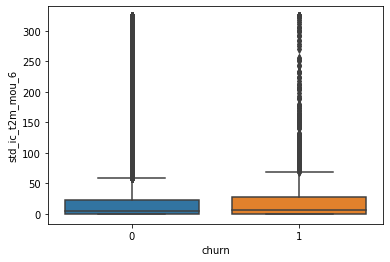

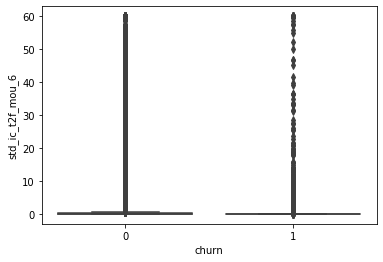

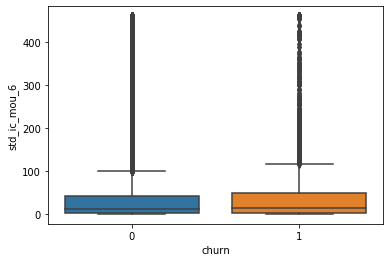

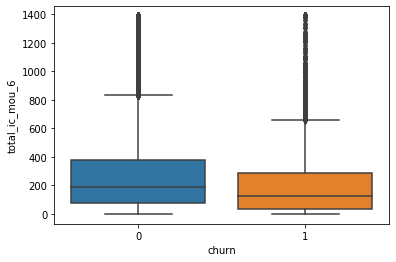

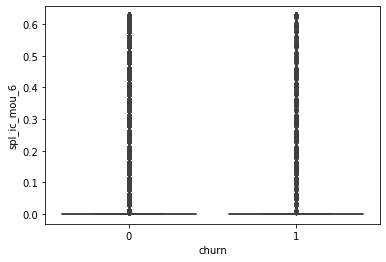

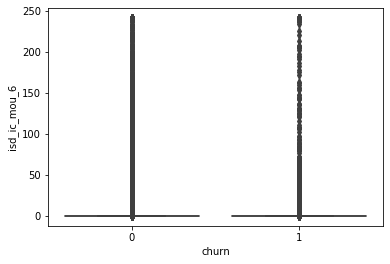

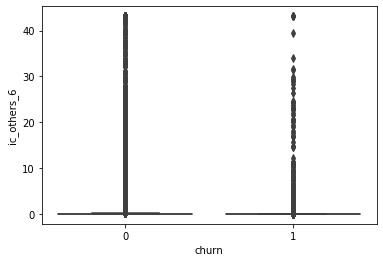

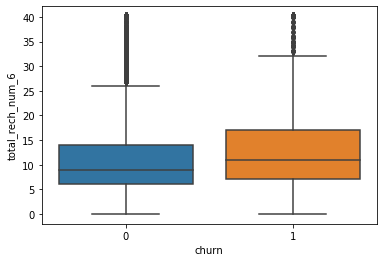

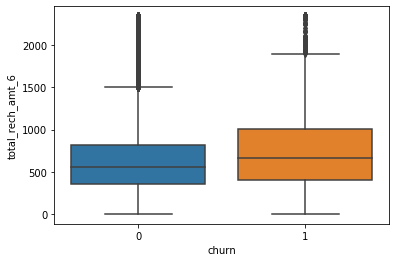

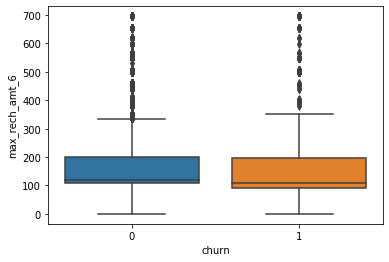

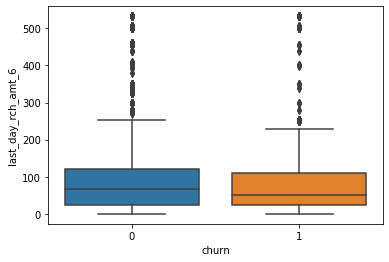

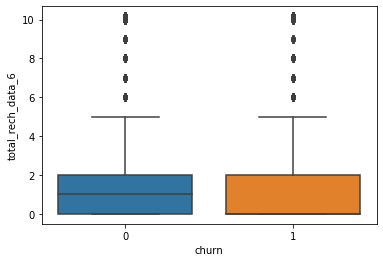

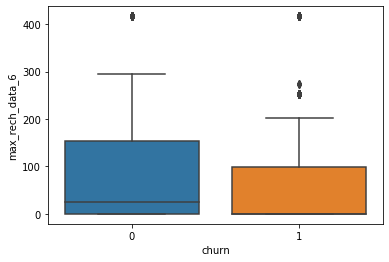

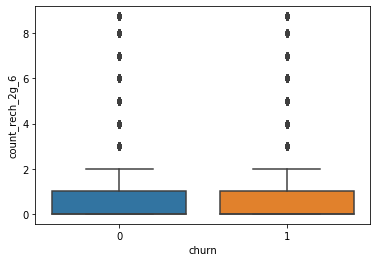

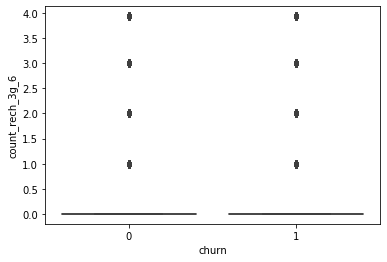

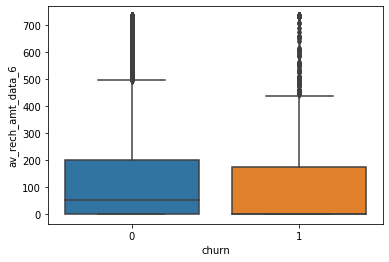

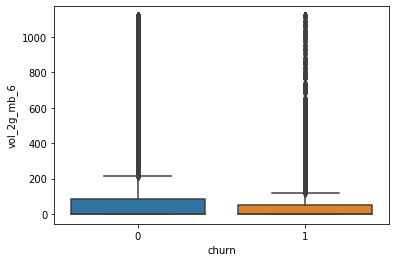

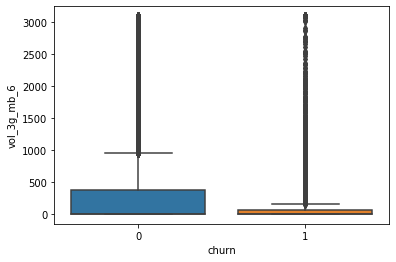

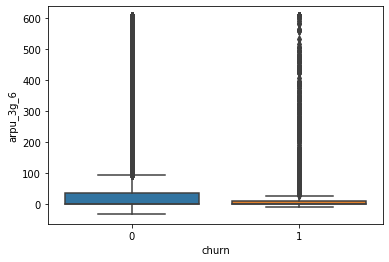

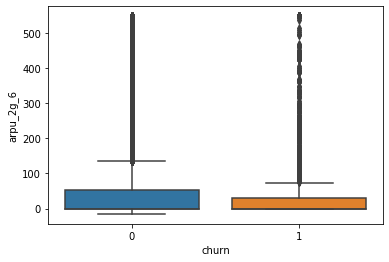

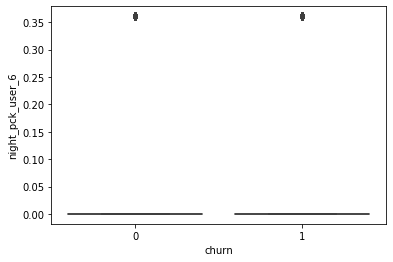

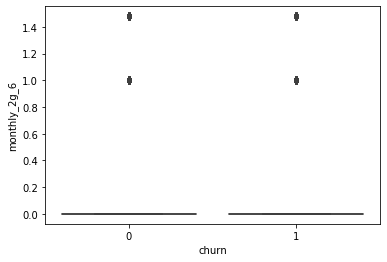

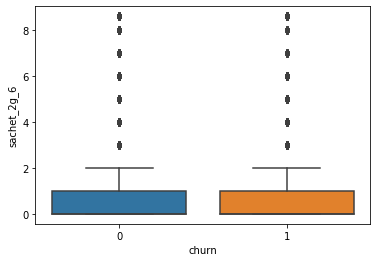

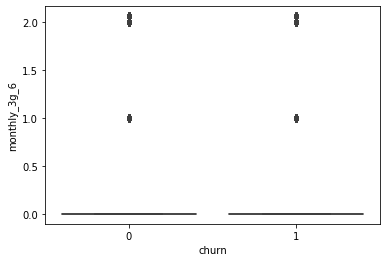

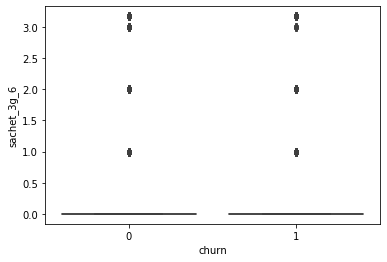

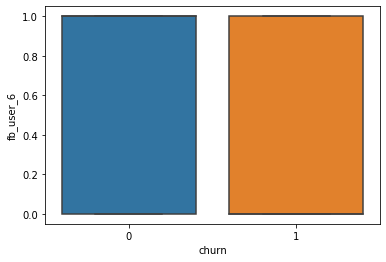

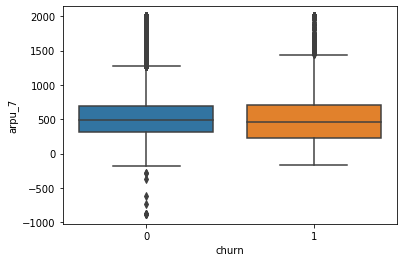

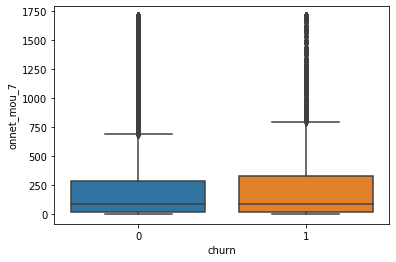

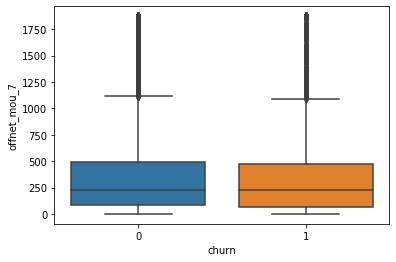

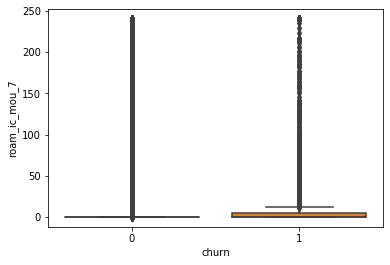

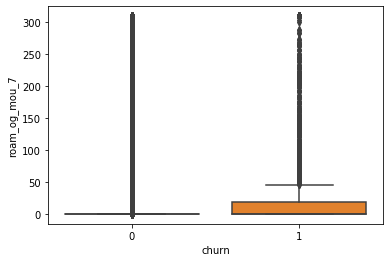

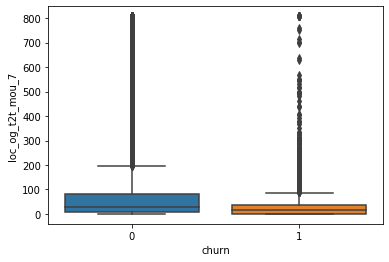

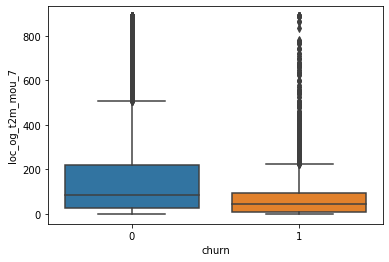

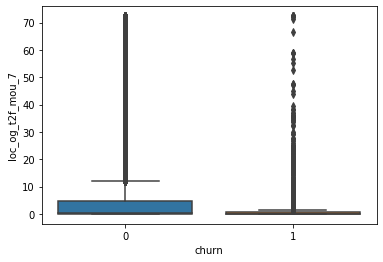

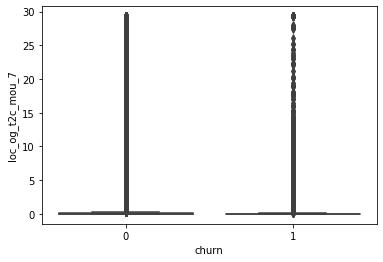

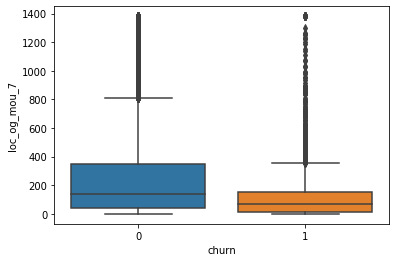

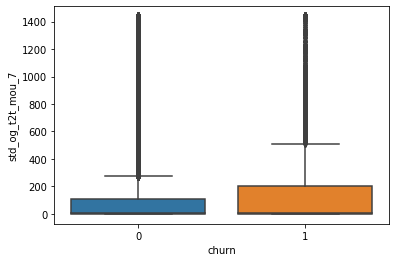

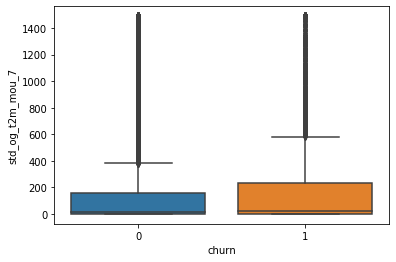

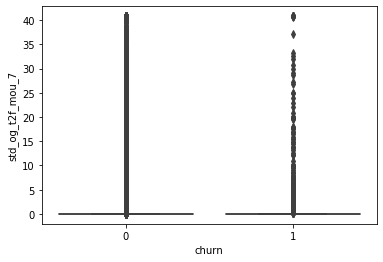

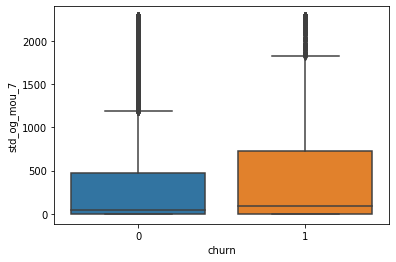

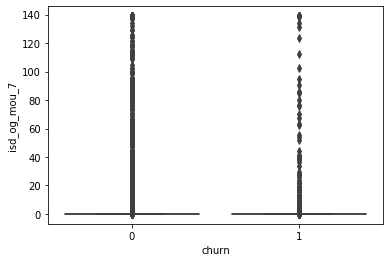

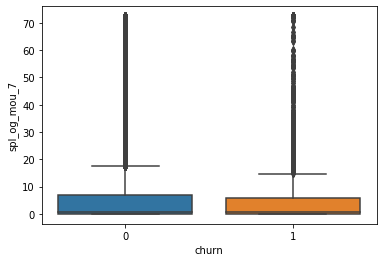

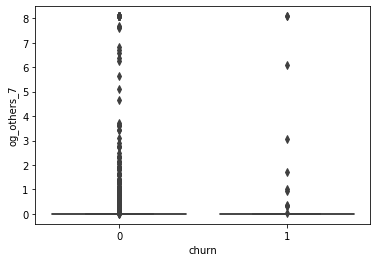

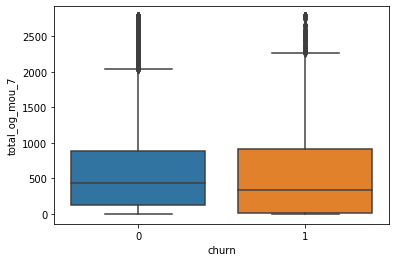

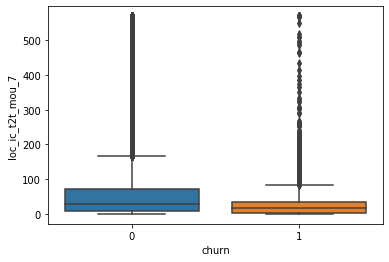

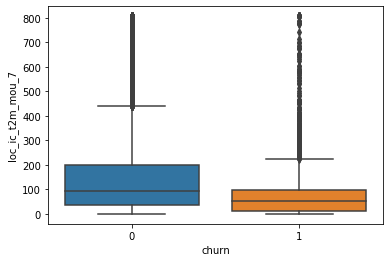

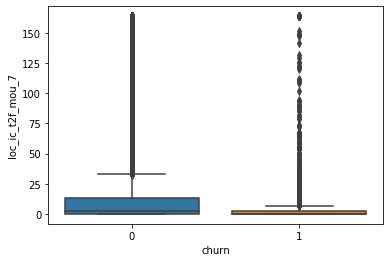

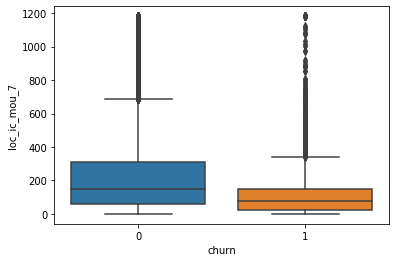

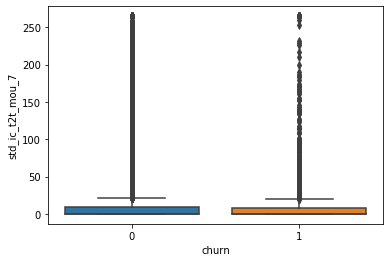

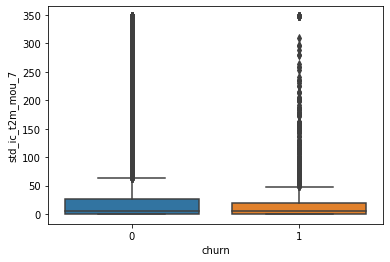

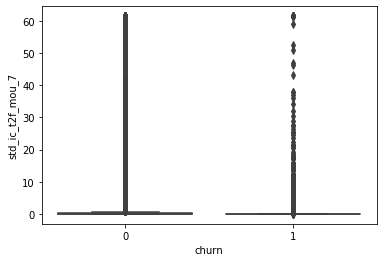

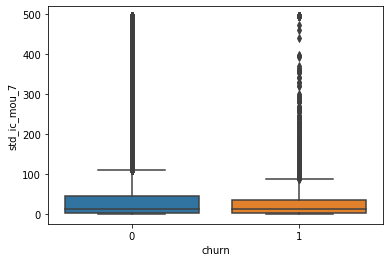

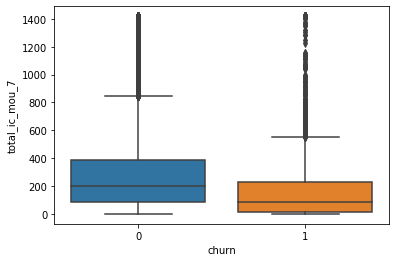

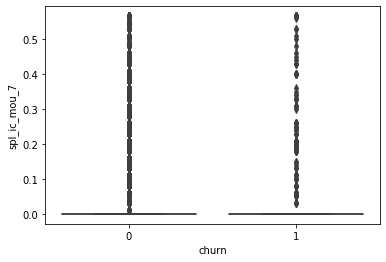

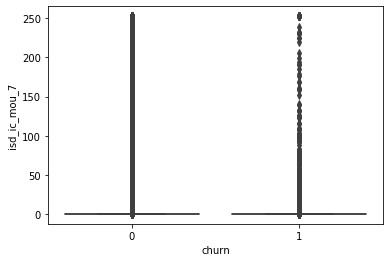

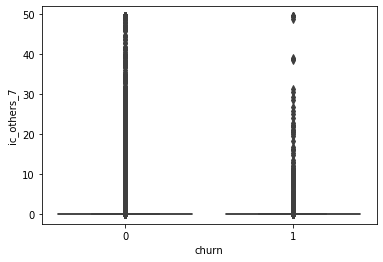

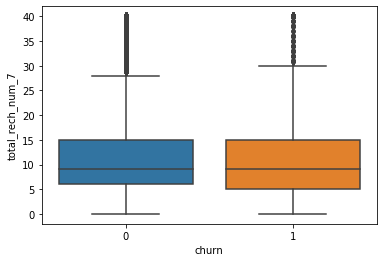

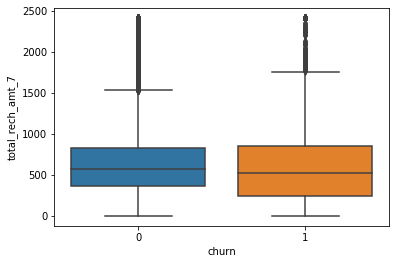

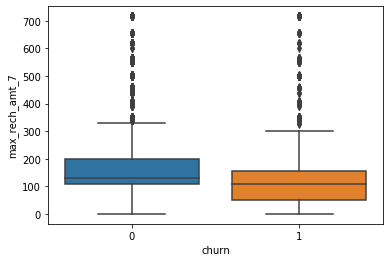

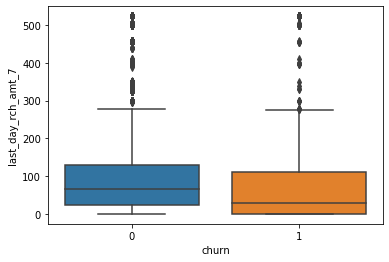

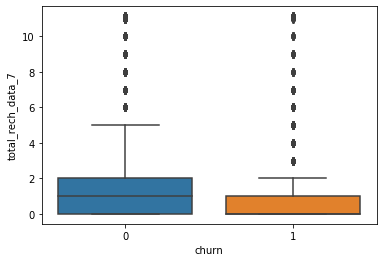

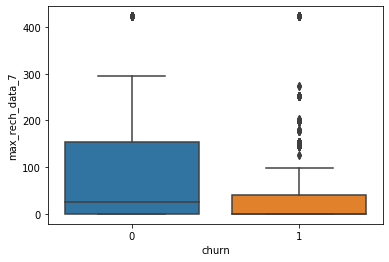

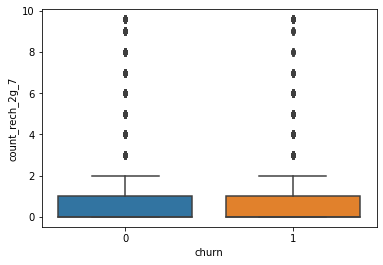

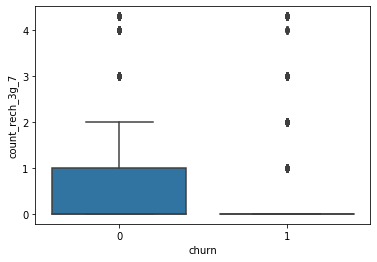

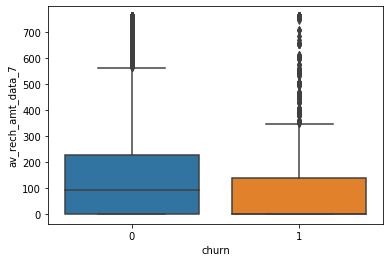

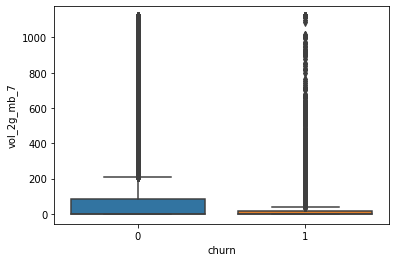

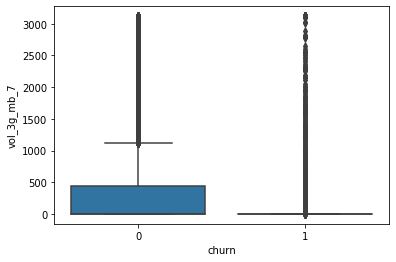

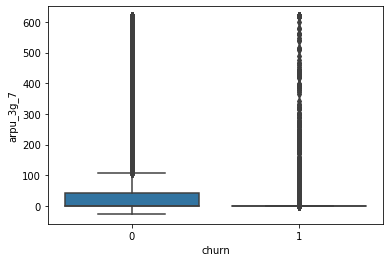

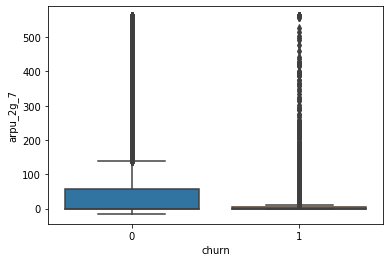

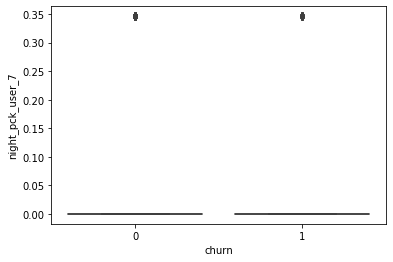

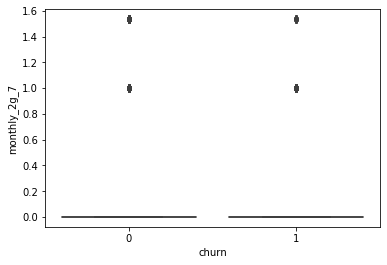

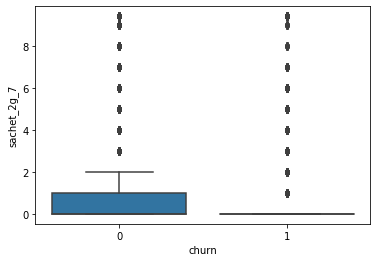

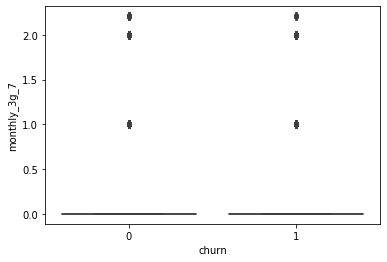

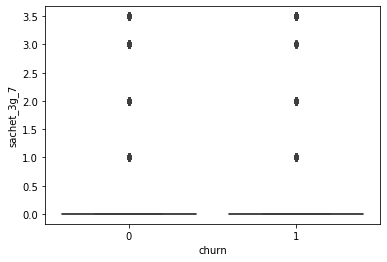

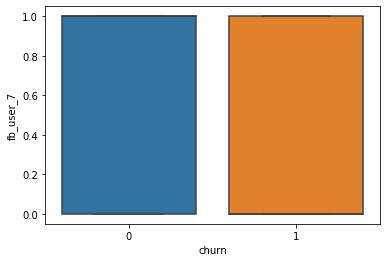

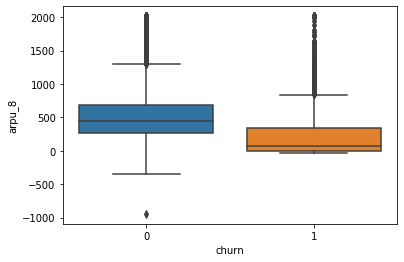

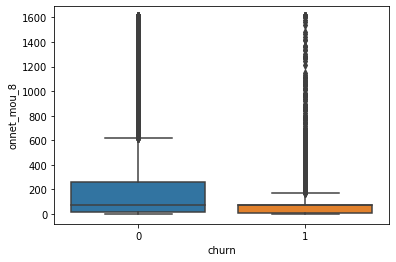

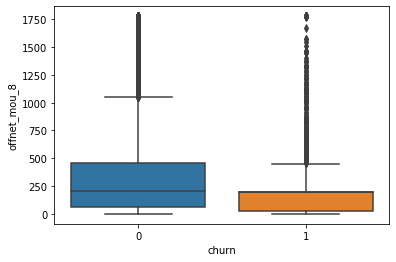

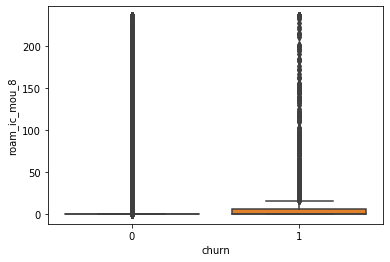

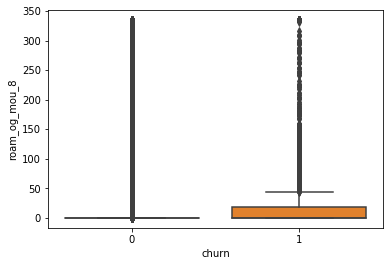

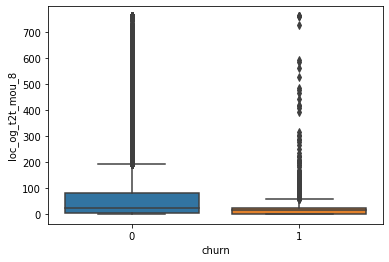

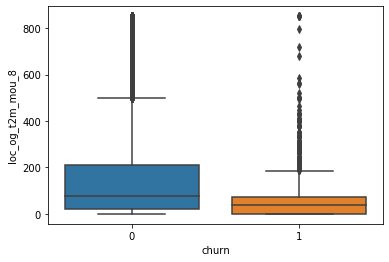

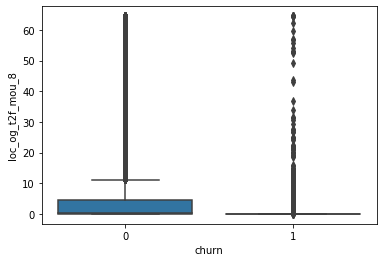

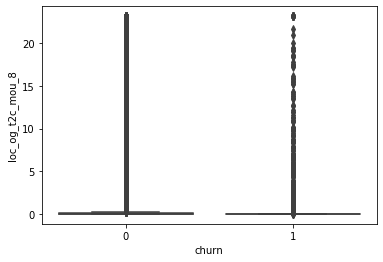

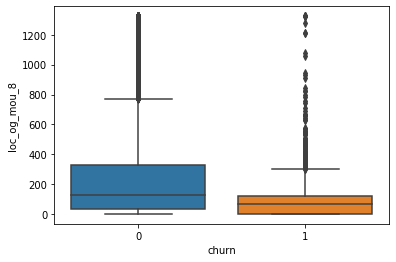

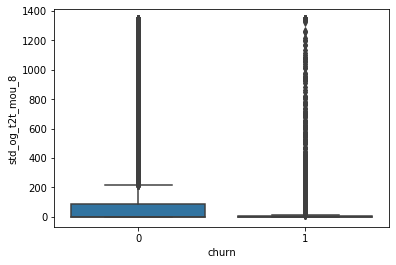

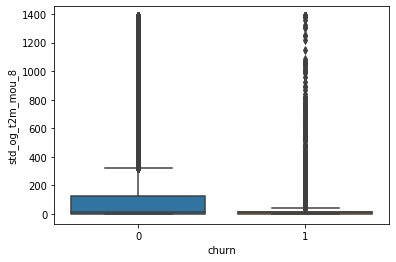

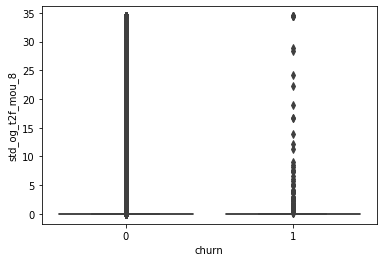

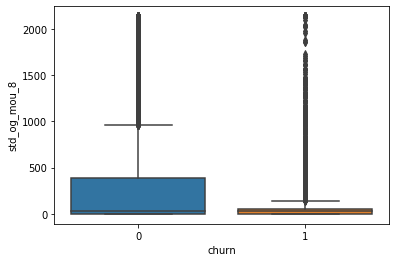

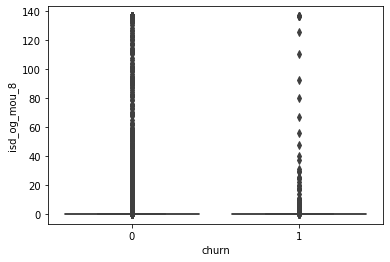

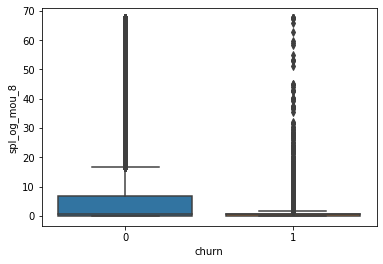

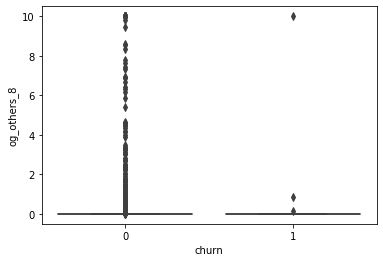

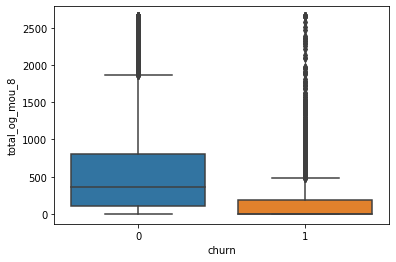

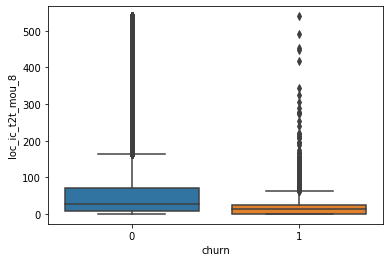

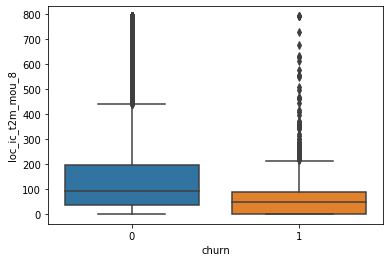

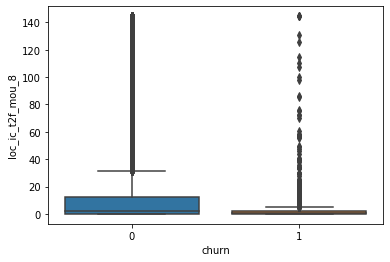

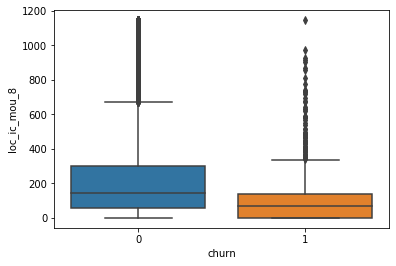

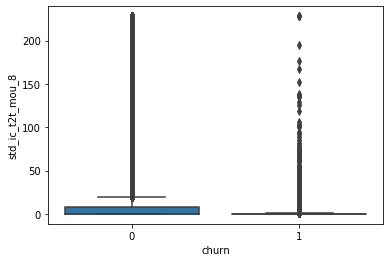

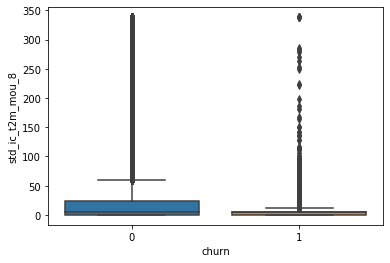

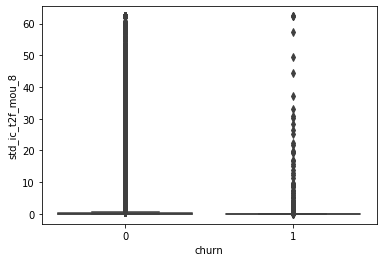

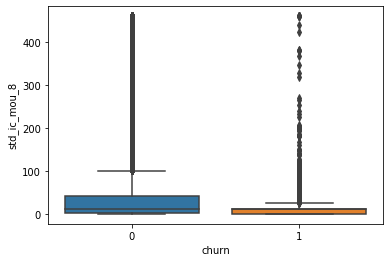

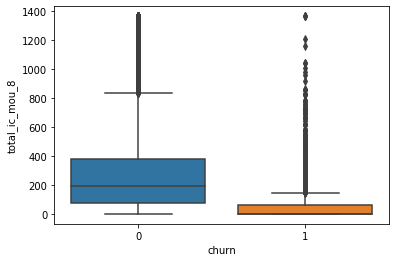

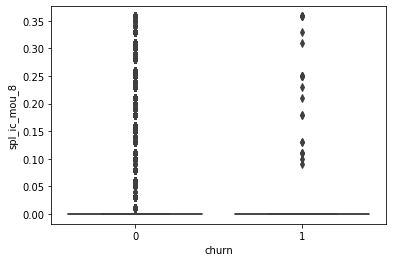

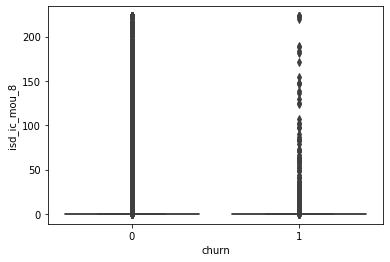

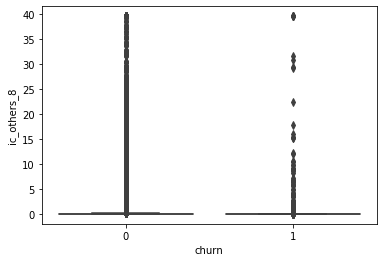

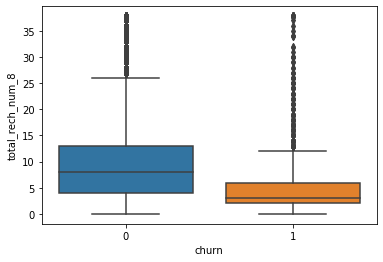

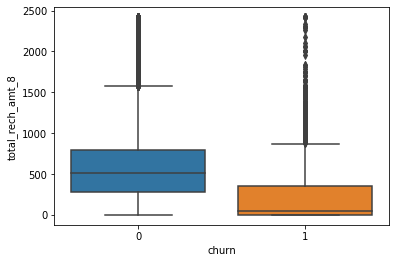

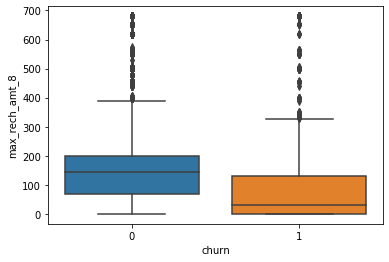

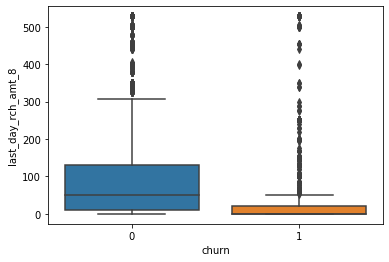

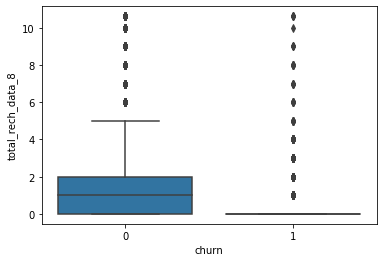

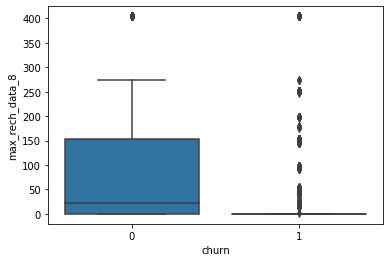

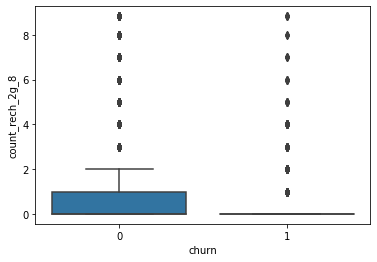

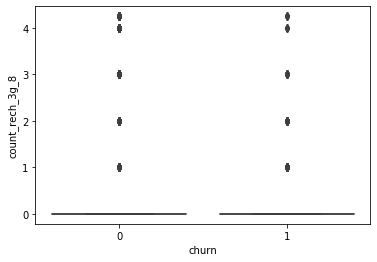

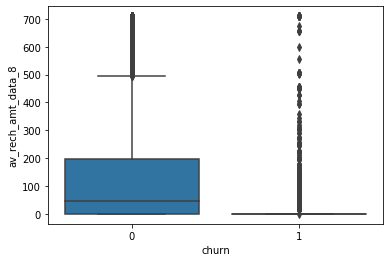

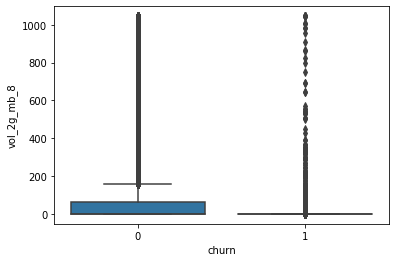

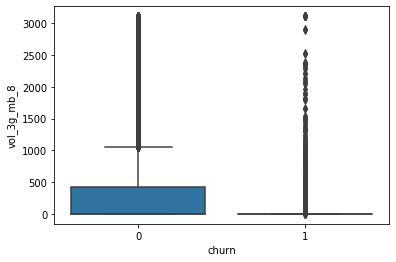

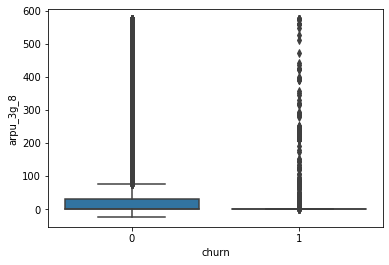

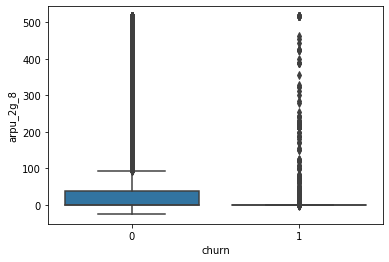

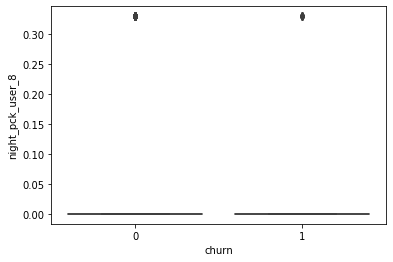

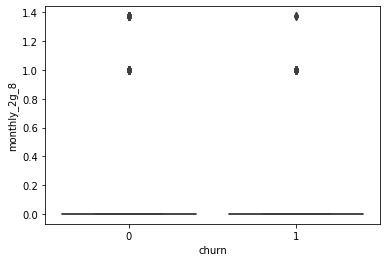

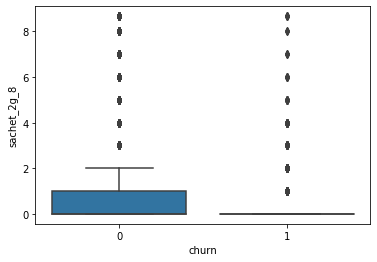

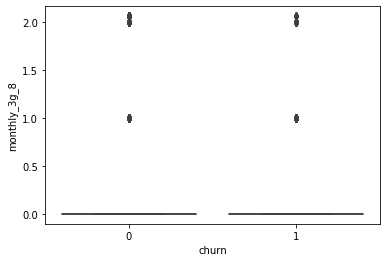

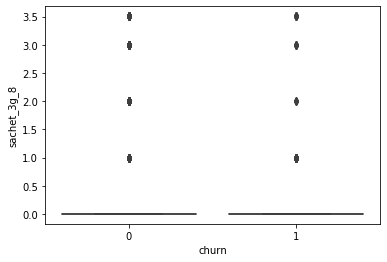

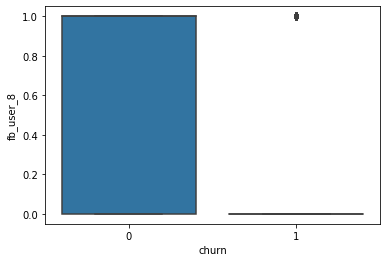

In [3]:
for col in col_diff+col_6+col_7+col_8:
    sns.boxplot(high_value_cust_drp2["churn"], high_value_cust_drp2[col])
    plt.show()

## Building the model

In [4]:
# because there is class imbalance let us use SMOTE to fix this issue before we go for prediction
TARGET_FEATURE = 'churn'
TEST_SET_SIZE = 0.3
raw_data = high_value_cust_drp2

x_data = raw_data.drop(TARGET_FEATURE, axis=1)
y_data = raw_data[TARGET_FEATURE]
# scaling the data
x_data=RobustScaler().fit_transform(x_data)

x_train_org, x_test, y_train_org, y_test = train_test_split(x_data, y_data, test_size=TEST_SET_SIZE, random_state=5)
# removing class imbalanace using SMOTE
oversampler=SMOTE(random_state=0)
x_train,y_train=oversampler.fit_sample(x_train_org,y_train_org)

### PCA with Logistic Regression

##### PCA for finding optimum number of principal components 

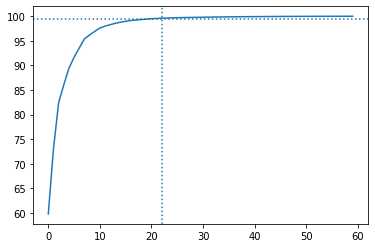

In [5]:
# We need to know how many components to make.
N_COMPONENTS = 60

# Fit the PCA model and get the PCA data.
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

pca_model = decomposition.PCA(n_components=N_COMPONENTS)
pca_model.fit(x_data)
pca_data = pd.DataFrame(pca_model.transform(x_data))

cumulative_variance = np.round(np.cumsum(pca_model.explained_variance_ratio_)*100, decimals=4)
plt.plot(cumulative_variance)
plt.axhline(99.5,ls=':')
plt.axvline(22,ls=':')

In [6]:
cumulative_variance

array([59.8058, 72.973 , 82.3675, 86.03  , 89.4045, 91.6374, 93.5212,
       95.3676, 96.1672, 96.895 , 97.5892, 97.9567, 98.2593, 98.5461,
       98.7603, 98.9534, 99.1102, 99.2047, 99.2983, 99.3859, 99.4683,
       99.5272, 99.5829, 99.6192, 99.6505, 99.6783, 99.7003, 99.7206,
       99.7391, 99.7572, 99.7748, 99.7921, 99.8094, 99.8256, 99.8393,
       99.8524, 99.8634, 99.8727, 99.8816, 99.8894, 99.897 , 99.9042,
       99.9112, 99.9175, 99.9235, 99.9292, 99.9348, 99.9401, 99.9447,
       99.9488, 99.9522, 99.9556, 99.9588, 99.9618, 99.9643, 99.9666,
       99.9686, 99.9706, 99.9724, 99.9741])

##### The PCA model shows 40 PCs can explain upto 98% of variance so let us take 40 PCs and build the LR model

#### Logistic Regression

In [7]:
N_COMPONENTS= 22
pca_model = decomposition.PCA(n_components=N_COMPONENTS)
pca_model.fit(x_data)
pca_data = pd.DataFrame(pca_model.transform(x_data))

# Set up the data for logistic regression.
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# To include an intercept, add a new column with a constant.
pca_data['intercept'] = 1.0

# Split the data into training and test sets.
x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(
    pca_data,
    y_data,
    test_size=TEST_SET_SIZE
)

# Fit the logistic regression model.
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# using class_weight balanced to fix class imbalance problem
logit_model = LogisticRegression(class_weight='balanced').fit(x_train_pca, y_train_pca)

# Get the results.
# ~~~~~~~~~~~~~~~
# Get prediction probabilities for the test set.
y_predict_proba = logit_model.predict_proba(x_test_pca)
predictions = logit_model.predict(x_test_pca)
print(logit_model.score(x_train_pca,y_train_pca))
print(logit_model.score(x_test_pca,y_test_pca))

0.780750703486431
0.7855553082572891


In [8]:
print(y_test_pca.value_counts())

0    8235
1     751
Name: churn, dtype: int64


In [9]:
print(classification_report(y_test_pca,predictions))

              precision    recall  f1-score   support

           0       0.97      0.79      0.87      8235
           1       0.24      0.70      0.35       751

    accuracy                           0.79      8986
   macro avg       0.60      0.75      0.61      8986
weighted avg       0.91      0.79      0.83      8986



In [10]:
confusion_matrix(y_test_pca, predictions)

array([[6536, 1699],
       [ 228,  523]], dtype=int64)

In [11]:
recall_score(y_test_pca, predictions)

0.6964047936085219

In [12]:
for x in [i/10 for i in range(10)]:
    THRESHOLD = x
    preds = np.where(y_predict_proba[:,1] > THRESHOLD, 1, 0)
    cm = confusion_matrix(y_test_pca, preds )
    print(cm)
    print(pd.DataFrame(data=[accuracy_score(y_test_pca, preds), recall_score(y_test_pca, preds),
                       precision_score(y_test_pca, preds), roc_auc_score(y_test_pca, preds)], 
                 index=["accuracy", "recall", "precision", "roc_auc_score"],columns=[THRESHOLD]))
    print(pd.Series(preds).value_counts())
    print("----------------")

[[   0 8235]
 [   0  751]]
                    0.0
accuracy       0.083574
recall         1.000000
precision      0.083574
roc_auc_score  0.500000
1    8986
dtype: int64
----------------
[[1156 7079]
 [  17  734]]
                    0.1
accuracy       0.210327
recall         0.977364
precision      0.093946
roc_auc_score  0.558870
1    7813
0    1173
dtype: int64
----------------
[[1798 6437]
 [  39  712]]
                    0.2
accuracy       0.279323
recall         0.948069
precision      0.099594
roc_auc_score  0.583203
1    7149
0    1837
dtype: int64
----------------
[[2644 5591]
 [  59  692]]
                    0.3
accuracy       0.371244
recall         0.921438
precision      0.110138
roc_auc_score  0.621253
1    6283
0    2703
dtype: int64
----------------
[[4338 3897]
 [  84  667]]
                    0.4
accuracy       0.556978
recall         0.888149
precision      0.146144
roc_auc_score  0.707463
1    4564
0    4422
dtype: int64
----------------
[[6536 1699]
 [ 228  523]

- at cutoff of 0.4 the recall is 89% and accuracy is also 56% but it is important to have identify more of chruners so recall or sensitivity is a good measure

### Random Forest Classification Model

In [13]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(x_train,y_train)

predictions=clf.predict(x_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, predictions))
print("OOB Score",clf.oob_score_)

Accuracy: 0.9364567104384598
OOB Score 0.9687711093790595


In [14]:
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      8275
           1       0.59      0.63      0.61       711

    accuracy                           0.94      8986
   macro avg       0.78      0.80      0.79      8986
weighted avg       0.94      0.94      0.94      8986

[[7968  307]
 [ 264  447]]


### Random Forest Classification with Cross Validation to find optimal Hyper parameters

In [15]:
pred_train = np.argmax(clf.oob_decision_function_,axis=1)

In [16]:
# Create the parameter grid based on the results of random search 

param_grid = {
    'max_depth': [4,8,10],
    'min_samples_leaf': range(100, 400, 200),
    'min_samples_split': range(200, 500, 200),
    'n_estimators': [100,200], 
    'max_features': [ 10, 15, 20]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1, scoring = 'recall')

In [17]:
# Fit the grid search to the data
grid_search.fit(x_train, y_train)
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed: 20.4min finished


We can get accuracy of 0.9084437516237984 using {'max_depth': 8, 'max_features': 20, 'min_samples_leaf': 100, 'min_samples_split': 200, 'n_estimators': 200}


In [18]:
# model with the best hyperparameters
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(bootstrap=True,
                             max_depth=grid_search.best_params_['max_depth'],
                             min_samples_leaf=grid_search.best_params_['min_samples_leaf'], 
                             min_samples_split=grid_search.best_params_['min_samples_split'],
                             max_features=grid_search.best_params_['max_features'],
                             n_estimators=grid_search.best_params_['n_estimators'])

In [19]:
rfc.fit(x_train,y_train)
predictions = rfc.predict(x_test)
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

           0       0.98      0.91      0.94      8275
           1       0.43      0.77      0.55       711

    accuracy                           0.90      8986
   macro avg       0.70      0.84      0.75      8986
weighted avg       0.94      0.90      0.91      8986

[[7551  724]
 [ 163  548]]


- In Random Forest Classification with optimum hyper parameters Precision, Sensitivity/recall and accuracy improved from those of Logistic Regression with PCA

##### Listing the important features from Random Forest Classification

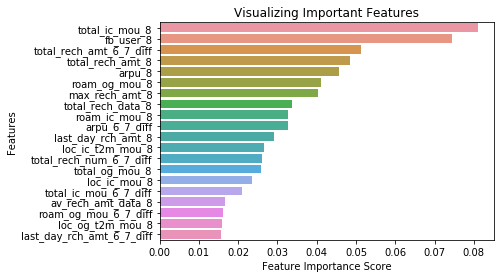

In [20]:
cols = list(raw_data.columns)
cols.remove(TARGET_FEATURE)
feature_imp = pd.Series(rfc.feature_importances_,index=cols).sort_values(ascending=False)
feature_imp_top = feature_imp.head(20)
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp_top, y=feature_imp_top.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

#### Checking if any correlation exists between the important features using heat map

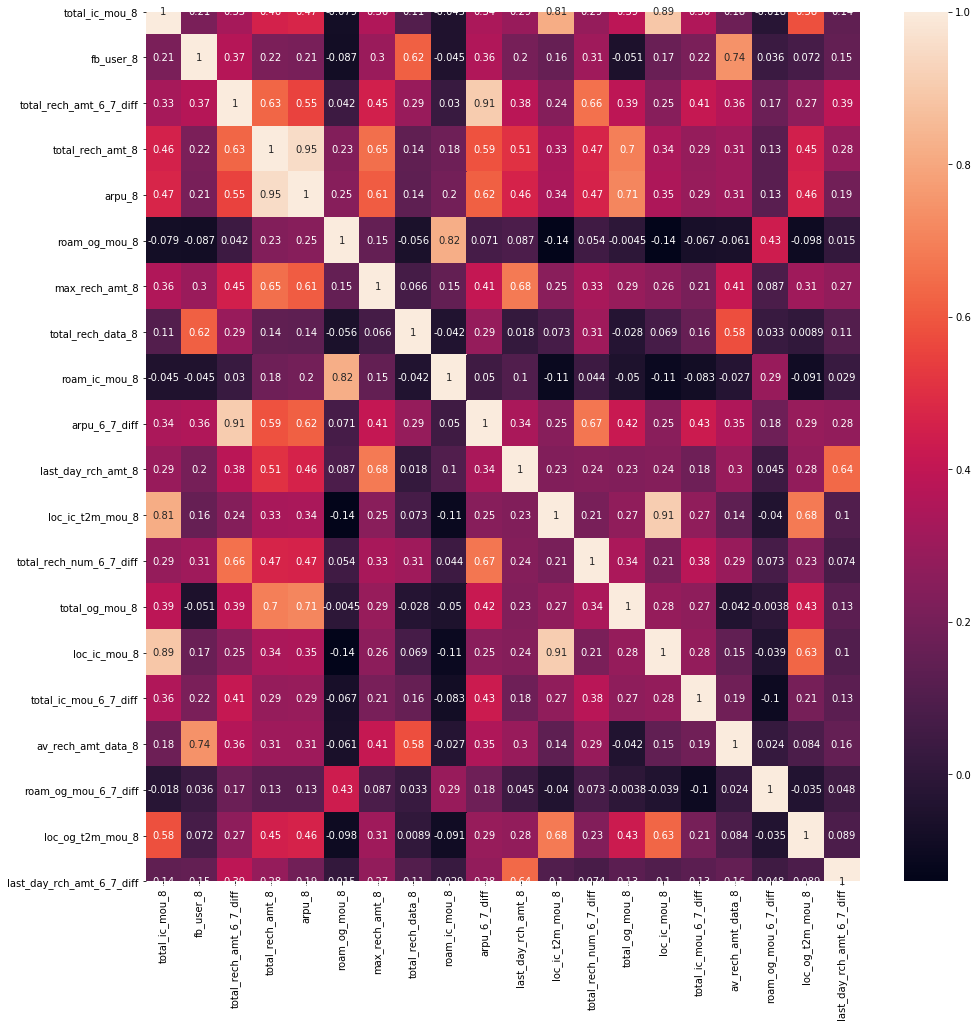

In [21]:
x_train_data = x_train.copy()
x_train_data = pd.DataFrame(x_train_data)
x_train_data.columns = cols
corr_data = x_train_data[list(feature_imp.index)[:20]].corr()
plt.figure(figsize=(16,16))
sns.heatmap(data=corr_data,annot=True)

In [22]:
selected_cols = list(feature_imp.index)[:20]
for col in ['total_og_mou_8', 'loc_ic_mou_8', 'fb_user_8']:
    selected_cols.remove(col)
X_data = raw_data[selected_cols]
y_data = raw_data[TARGET_FEATURE]

X_data=RobustScaler().fit_transform(X_data)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=TEST_SET_SIZE, random_state=5)
oversampler=SMOTE(random_state=0)
X_train,y_train=oversampler.fit_sample(X_train,y_train)

##### Understanding distribution of selected important features to be used as features from logistic regression with cross validation

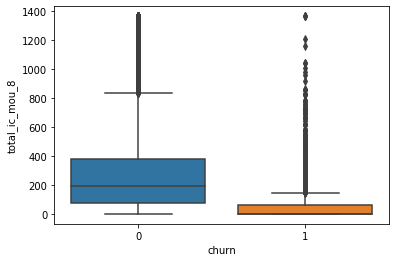

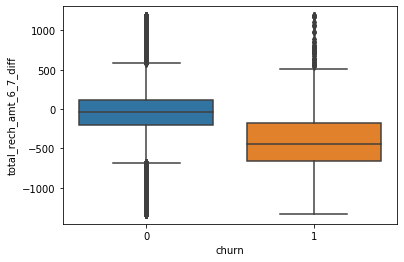

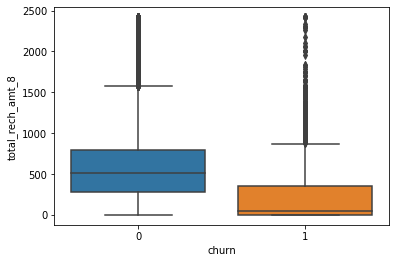

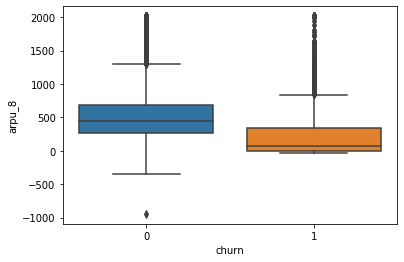

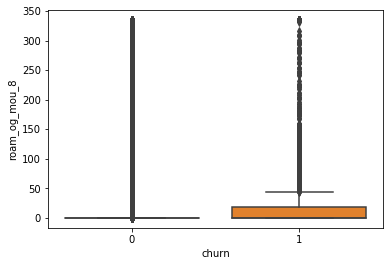

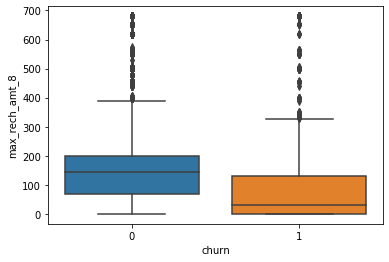

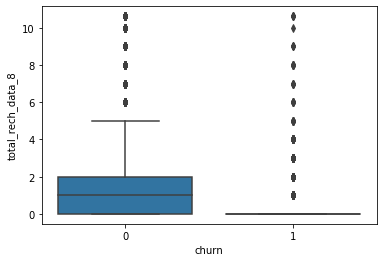

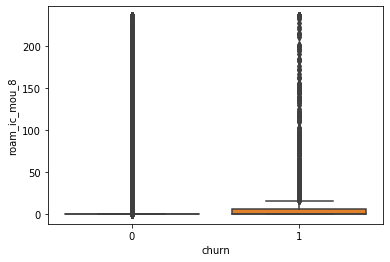

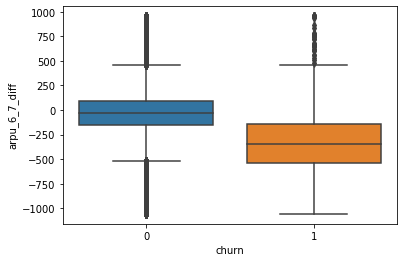

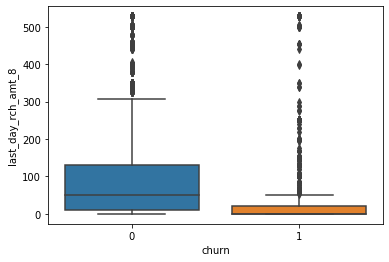

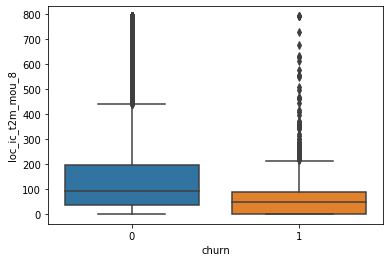

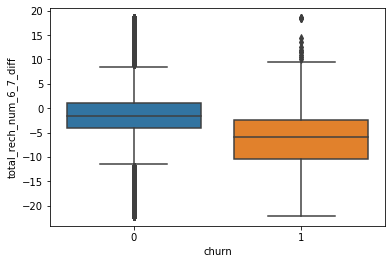

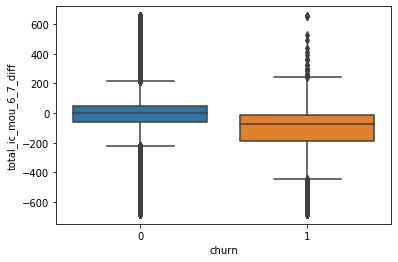

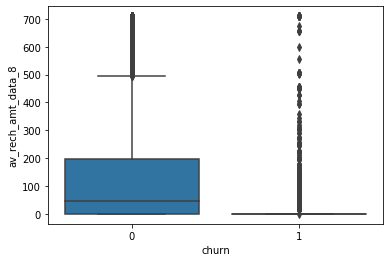

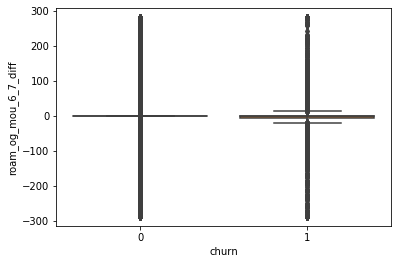

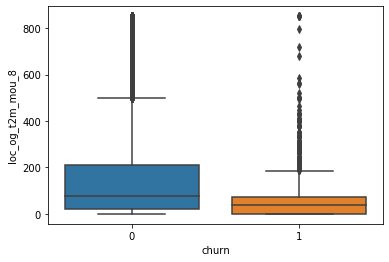

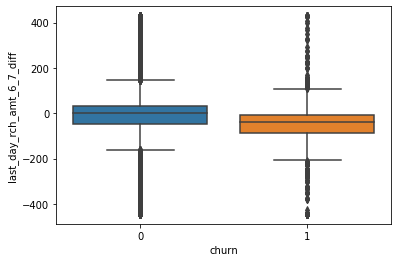

In [23]:
for col in selected_cols:
    sns.boxplot(high_value_cust_drp2["churn"], high_value_cust_drp2[col])
    plt.show()

#### Logistic Regression with cross validation

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
# logistic regression
steps = [('scaler', StandardScaler()), 
         ("logistic", LogisticRegression(class_weight={0:0.1, 1:0.9}))
        ]

# compile pipeline
logistic = Pipeline(steps)

# hyperparameter space
params = {'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10], 'logistic__penalty': ['l1', 'l2']}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
model = GridSearchCV(estimator=logistic, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)

In [25]:
# fit model
model.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    3.4s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('logistic',
                                        LogisticRegression(C=1.0,
                                                           class_weight={0: 0.1,
                                                                         1: 0.9},
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
      

In [26]:
# print best hyperparameters
print("Best AUC: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best AUC:  0.8941912753333643
Best hyperparameters:  {'logistic__C': 1, 'logistic__penalty': 'l2'}


#### Building the final Logistic Regression Model with selected hyper parameter from the best model

In [27]:
y_pred = model.predict(X_test)

# create onfusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

from imblearn.metrics import sensitivity_specificity_support
# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = model.predict_proba(X_test)[:, 1]
print("ROC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

[[2598 5677]
 [  21  690]]
Sensitivity: 	0.97
Specificity: 	0.31
ROC:    	 0.88


In [28]:
logistic_model = model.best_estimator_.named_steps['logistic']

In [29]:
# intercept
intercept_df = pd.DataFrame(logistic_model.intercept_.reshape((1,1)), columns = ['intercept'])

In [30]:
coefficients = logistic_model.coef_.reshape((len(selected_cols), 1)).tolist()
coefficients = [val for sublist in coefficients for val in sublist]
coefficients = [round(coefficient, 3) for coefficient in coefficients]

logistic_features = selected_cols
coefficients_df = pd.DataFrame(logistic_model.coef_, columns=logistic_features)

In [31]:
# concatenate dataframes
coefficients = pd.concat([intercept_df, coefficients_df], axis=1)
coefficients

,intercept,total_ic_mou_8,total_rech_amt_6_7_diff,total_rech_amt_8,arpu_8,roam_og_mou_8,max_rech_amt_8,total_rech_data_8,roam_ic_mou_8,arpu_6_7_diff,last_day_rch_amt_8,loc_ic_t2m_mou_8,total_rech_num_6_7_diff,total_ic_mou_6_7_diff,av_rech_amt_data_8,roam_og_mou_6_7_diff,loc_og_t2m_mou_8,last_day_rch_amt_6_7_diff
0,1.950985,-0.97178,-0.062371,-0.242453,0.199868,0.393119,0.203577,-0.588995,0.046401,-0.277619,-0.376492,0.351993,-0.419831,-0.24034,-0.255446,-0.047084,-0.482523,-0.033878


In [40]:
coefficients.T.sort_values(by=0)

,0
total_ic_mou_8,-0.971780
total_rech_data_8,-0.588995
loc_og_t2m_mou_8,-0.482523
total_rech_num_6_7_diff,-0.419831
last_day_rch_amt_8,-0.376492
arpu_6_7_diff,-0.277619
av_rech_amt_data_8,-0.255446
total_rech_amt_8,-0.242453
total_ic_mou_6_7_diff,-0.240340
total_rech_amt_6_7_diff,-0.062371


#### Final Assessment

- if the coefficients of the features are negative then the decrease in the value of feature will increase the odds of churn
    - if total_ic_mou_8 decreases odds of churn is high
    - if total_rech_num_6_7_diff(difference in total recharge between good phase and action phase has decreased) then odds of churn is high
- if the coefficients of the features are positive then the increase in the value of feature will increase the odds of churn
    - if roam_og_mou_8 or roam_ic_mou_8 increases odds of churn is high
    - if loc_ic_t2m_mou_8 increases odds of churn is high

### Recommendation

- The company should work on decreasing the roaming charge
- Company should provide some better data recharge option to hold their customers
- most of cases if there is decline in services from good period to action phase the customers churn so the company should track those customers to avail them better offers

## Thank You!!!